RDD on CN data

# Data sources

From x.com we download the raw data (including notes-00000.tsv)

On HPC we apply the scoring algorithsms, generating output in parquet format

We preprocess and merge these files using

    preprocess_dates.py
    merge_ratings_with_notes.py

# Environment

see requirements.txt or communitynotes2025-05-09.yml

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import calendar
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap

# files and locations

userloc = '/home/tomstafford/Desktop/communitynotes/' #thinkpad
userloc = '/home/tom/Desktop/communitynotes/' #xps
data_raw = userloc+'data2025raw/' # download from x.com
data_proc = userloc+'data2025proc/' # generating by CN code, run on HPC
data_post = userloc+'data2025post/' # post-processing, generated by our scripts

# TODO

add data prep instructions

## RDD

**Research question(s)**: Is it a problem that such a low proportion of notes are rated as helpful ? Restated, at the individual level: Does having a note rated as helpful encourage future contributions, and conversely, does not having a note rated as helpful discourage future contributions. Our unit of analysis is the individuals in the CN system: how are they affected by what happens to their notes?

**Design**: regression discontinuity, comparing notes around threshold for being rated helpful

**Candidate set**: all first-time note authors (yes, most notes might be authored by a minority of repeat authors, but these people are already committed to CN and/or are the people least likely to be influenced by note success, *and* I think the effect on people who have just jointed CN is the one we are most interested in). We will look at the first note of first time note authors only.

(option: we could just look at the first note of 2024, rather than of all time)

**Outcome measure**: does the first time note author go on to author another note? (ie in the rest of 2024).

**Predictors**: there is this issue of notes flip-flopping between helpful and unhelpful. After two weeks a note's status is fixed, and a note author receives notifications each time the note status changes. To create a tractable analysis, consider these two simplifications

A. Final outcome: either Helpful (1) or Unhelpful (0), ignoring all prior status history. We compare notes whose final score was just above and below threshold for this. Call this H

B. Notification occurrence : note author received a notification that the note was rated helpful (1), or never did (0). We compare notes whose maximum all time score was just above or below threshold for this. Call this N

Note that the two predictors define two, distinct, subsets of the candidates (ie you can't just throw both predictors into the same regression, since authors who have a relevant score for H may not have a value for N, and vice versa)

In [2]:
# First let's inmport the data anbd count how many notes we have

rated = pd.read_parquet(data_post+'rated_notes_compact.parquet', engine='auto')

len(rated) #1,946,619 for 2025 data

1946619

In [3]:
#Restricting our analysis to only 2024 notes

rated_2024 = rated[(rated.createdAt >= pd.Timestamp(2024, 1, 1)) &
                    (rated.createdAt < pd.Timestamp(2025, 1, 1))]

In [4]:
# Find the first note written by each author, and if that author goes on to write another note
first_notes = rated_2024.groupby('noteAuthorParticipantId')\
    [['finalRatingStatus', 'numRatings', 'decidedBy','coreNoteIntercept', 'coreNoteInterceptMax']]\
    .first().reset_index()
have_another_note = rated_2024[rated_2024.groupby('noteAuthorParticipantId').cumcount() >= 2]\
    ['noteAuthorParticipantId'].to_list()
first_notes['if_written_again'] = first_notes['noteAuthorParticipantId'].isin(have_another_note)

In [5]:
# notes are scored by multiuple algorithms, but nearly 80% are scored by the core model
#  for now  restrict our analysis to thismodel
first_notes = first_notes[first_notes['decidedBy'] == 'CoreModel (v1.1)']

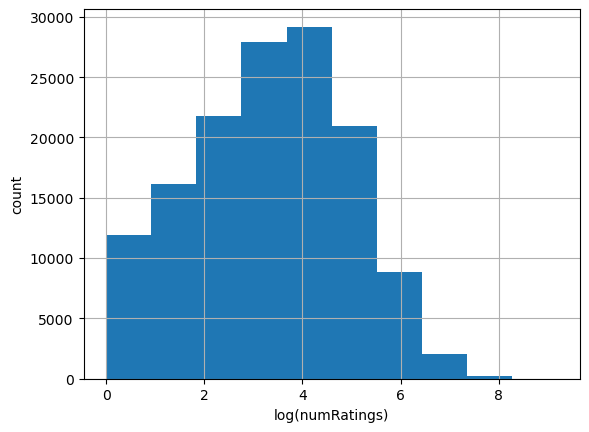

In [6]:
# Most notes have a small number of rating, a small number have very many ratinhgs
# This means the distribution of ratings is very skewed.
# We take the log of the number of ratings to make the distribution more normal


first_notes['log_numRatings']=np.log(first_notes['numRatings'])

first_notes['log_numRatings'].hist() #normal
plt.xlabel('log(numRatings)')
plt.ylabel('count')
plt.show()



In [7]:
# Most notes don't receive enough ratings to be labelled helpful (and shown), or label unhelpful

first_notes['finalRatingStatus'].value_counts()

finalRatingStatus
NEEDS_MORE_RATINGS             123855
CURRENTLY_RATED_HELPFUL          9440
CURRENTLY_RATED_NOT_HELPFUL      5620
Name: count, dtype: int64

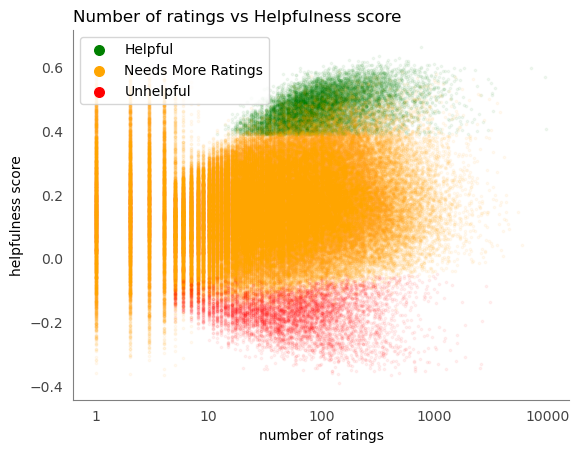

In [8]:
# Plotting log(numRatings) vs coreNoteInterceptMax, with colours according to Note final status (finalRatingStatus )  
ax = plt.subplot()
groups = ['CURRENTLY_RATED_HELPFUL','NEEDS_MORE_RATINGS','CURRENTLY_RATED_NOT_HELPFUL']
colours=['green','orange','red']

ms=3;alphaval=0.05;

for i in range(3):
    ax.scatter(first_notes[first_notes['finalRatingStatus']==groups[i]]['numRatings'], 
                first_notes[first_notes['finalRatingStatus']==groups[i]]['coreNoteIntercept'], 
                s = ms,alpha=alphaval,color=colours[i],label=groups[i])  

# Most notes have a small number of rating, a small number have very many ratings
# This means the distribution of ratings is very skewed.
# We take the log of the number of ratings to make the distribution more normal
ax.set_xscale('log')
# change x ticklabels to non-log scale
ax.xaxis.set_major_formatter(ScalarFormatter())
# hide minor ticks
plt.minorticks_off()

ax.set_xlabel('number of ratings')
ax.set_ylabel('helpfulness score')
ax.set_title('Number of ratings vs Helpfulness score', loc='left')
legends = plt.legend(['Helpful', 'Needs More Ratings', 'Unhelpful'], loc='upper left',markerscale=4)
# modify alpha level for legends
for lh in legends.legend_handles: 
    lh.set_alpha(1)

# remove right and upper spine
ax.spines[['right', 'top']].set_visible(False)
# change other spines colors to gray
ax.spines[['bottom', 'left']].set_color("grey")
ax.tick_params(axis='both', colors="#444444", left=False, bottom=False)
plt.savefig('plots/scatter_numRatings_coreNoteIntercept.png',dpi=120,bbox_inches='tight')
plt.show()

# Intepretation:

There is a discontinuity: although some notes labelled NEEDS_MORE_RATINGS have a score above 0.4, no notes with a score below 0.4 have a label CURERENTLY_RATED_HELPFUL

This establishes the logic required for our analaysis

# Now, the RDD

In [9]:
# RDD 

cutoff = 0.4 #threshold at which a note is rated as helpful
bandwidth = 0.05 #window around cutoff

# We fit a model allowing for different intercepts and slopes on either side of the cutoff.

# most recent score
running_variable = first_notes['coreNoteIntercept'] # x value, continuous input

# highest score
#running_variable = first_notes['coreNoteInterceptMax'] # x value, continuous input

# Treatment = 1 if running_variable >= cutoff, else 0
treatment = np.where(running_variable >= cutoff, 1, 0)

#
outcome_variable = first_notes['if_written_again'].astype(int) # y value, binary output

# we can restrict the analysis to a window (bandwidth) around the cutoff.

mask = (running_variable > cutoff - bandwidth)  & (running_variable < cutoff + bandwidth)

data = pd.DataFrame({
    'running_variable': running_variable[mask],
    'treatment': treatment[mask],
    'outcome_variable': outcome_variable[mask],
    'control' : first_notes[mask]['log_numRatings'],
    'numRatings' : first_notes[mask]['numRatings']
})

# Center the running variable at the cutoff for easier interpretation of the intercept
data['running_variable_centered'] = data['running_variable'] - cutoff

print("Sample Data Head:")
print(data.head())
print(f"\nNumber of treated units: {data['treatment'].sum()}")
print(f"Number of control units: {data['treatment'].count() - data['treatment'].sum()}")


Sample Data Head:
    running_variable  treatment  outcome_variable   control  numRatings  \
13          0.415720          1                 1  1.098612           3   
45          0.384220          0                 0  5.533389         253   
48          0.365476          0                 1  3.465736          32   
74          0.371758          0                 1  1.386294           4   
98          0.424668          1                 0  5.509388         247   

    running_variable_centered  
13                   0.015720  
45                  -0.015780  
48                  -0.034524  
74                  -0.028242  
98                   0.024668  

Number of treated units: 4664
Number of control units: 5265


In [10]:
#let's see how many notes are in our analysis, around the cutoff

data.groupby('treatment')['numRatings'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,5265.0,125.487939,190.820453,1.0,31.0,68.0,146.0,3042.0
1,4664.0,126.316895,244.152051,1.0,38.0,69.0,136.0,9806.0


In [11]:

# original
rdd_model_formula = 'outcome_variable ~ running_variable_centered * treatment'
#rdd_model_formula = 'outcome_variable ~ running_variable_centered * treatment + control'
rdd_model = smf.ols(formula=rdd_model_formula, data=data).fit()

print("\nRDD Model Summary (using all data):")
print(rdd_model.summary())


RDD Model Summary (using all data):
                            OLS Regression Results                            
Dep. Variable:       outcome_variable   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.628
Date:                Sat, 23 Aug 2025   Prob (F-statistic):           0.000752
Time:                        15:47:00   Log-Likelihood:                -7197.9
No. Observations:                9929   AIC:                         1.440e+04
Df Residuals:                    9925   BIC:                         1.443e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [12]:
# The coefficient for 'treatment' is the estimated effect at the cutoff.
# aka the LATE
estimated_effect = rdd_model.params['treatment']
std_error = rdd_model.bse['treatment']

print(f"Estimated Treatment Effect at the Cutoff: {estimated_effect:.4f}")
print(f"Standard Error: {std_error:.4f}")

print("\nI think we can intepret this as a % change the chance of authoring again if published")

p_value_treatment = rdd_model.pvalues['treatment']
t_statistic_treatment = rdd_model.tvalues['treatment']
conf_int_treatment = rdd_model.conf_int().loc['treatment']

# print out p value and t-statistic for treatment

print(f"\nP-value for treatment: {p_value_treatment:.4f}")
print(f"T-statistic for treatment: {t_statistic_treatment:.4f}")
print(f"Confidence interval for treatment: " + str(conf_int_treatment))



Estimated Treatment Effect at the Cutoff: 0.0540
Standard Error: 0.0200

I think we can intepret this as a % change the chance of authoring again if published

P-value for treatment: 0.0071
T-statistic for treatment: 2.6923
Confidence interval for treatment: 0    0.014671
1    0.093237
Name: treatment, dtype: float64


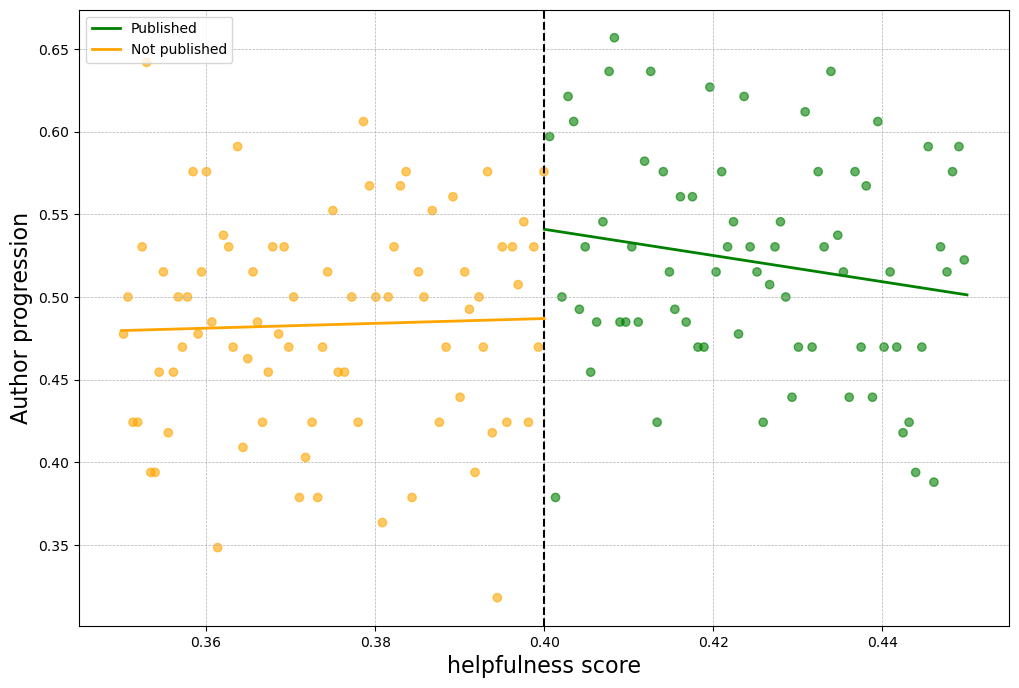

In [15]:
# 3. Visualization
plt.figure(figsize=(12, 8))

bins=150

#bin data
data['bin'] = pd.qcut(data['running_variable'], bins)

y = data.groupby('bin',observed=False).mean()

colors = ListedColormap(['orange','green'])

plt.scatter(y['running_variable'], y['outcome_variable'],
            c=y['treatment'], cmap=colors, alpha=0.6) 

# Plot regression lines for each side of the cutoff
# For values below the cutoff (treatment=0)
x_below = np.linspace(data['running_variable'].min(), cutoff, 100)
y_below = rdd_model.params['Intercept'] + rdd_model.params['running_variable_centered'] * (x_below - cutoff)

# For values above the cutoff (treatment=1)
x_above = np.linspace(cutoff, data['running_variable'].max(), 100)
y_above = (rdd_model.params['Intercept'] + rdd_model.params['treatment']) + \
          (rdd_model.params['running_variable_centered'] + rdd_model.params['running_variable_centered:treatment']) * (x_above - cutoff)

plt.plot(x_above, y_above, color='green', linestyle='-', linewidth=2, label='Published')
plt.plot(x_below, y_below, color='orange', linestyle='-', linewidth=2, label='Not published')


plt.axvline(x=cutoff, color='black', linestyle='--')
plt.xlabel('helpfulness score',size = 16)
plt.ylabel('Author progression',size = 16)
#plt.title('Regression Discontinuity Design')
plt.legend(loc='upper left',markerscale=24)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('plots/RDD.png',bbox_inches='tight',dpi=120)
plt.show()

# Sensitivity analysis

Our main result is an effect of 0.0540 with a p-value of 0.0071\n
To rest the robustness of these results we rerun with different threshold (original 0.4) or bandwidth (original 0.0.05)

## Varying threshold

| threshold | Effect | p-value |
| :--- | :--- | :--- |
| 0.5 | -0.037 | 0.1249 |
| 0.4 | +0.054 | 0.0071 |
| 0.3 | -0.010 | 0.4917 |

## Varying window size

| window | Effect | p-value | observations |
| :--- | :--- | :--- | :--- |
| 0.025 | +0.050 | 0.0785 | 4819 |
| 0.05 | +0.054 | 0.0071 | 9929 |
| 0.1 | +0.040 | 0.0043 | 21949 |
